# IMPORTS AND FUNCTIONS

In [7]:
import datetime
import pandas as pd
from erddapy import ERDDAP
import utils
from tqdm.notebook import tqdm
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import gsw
import cmocean.cm as cmo
from scipy import optimize 

from scipy.interpolate import interp1d, interp2d
def interpt(x,y,xi):
    _gg = np.isfinite(x.astype('float')+y)
    return interp1d(x[_gg].astype('float'), y[_gg], bounds_error=False, fill_value=np.NaN)(xi.astype('float'))

In [8]:
def grid2d(x, y, v, xi=1, yi=1, fn='median'):
    if np.size(xi) == 1:
        xi = np.arange(np.nanmin(x), np.nanmax(x)+xi, xi)
    if np.size(yi) == 1:
        yi = np.arange(np.nanmin(y), np.nanmax(y)+yi, yi)

    raw = pd.DataFrame({'x':x,'y':y,'v':v}).dropna()

    grid = np.full([np.size(yi),np.size(xi)], np.nan)
    
    raw['xbins'],xbin_iter = pd.cut(raw.x, xi,retbins=True,labels=False, right=False)
    raw['ybins'],ybin_iter = pd.cut(raw.y, yi,retbins=True,labels=False, right=False)

    _tmp = raw.groupby(['xbins','ybins'])['v'].agg(fn)
    grid[_tmp.index.get_level_values(1).astype(int),_tmp.index.get_level_values(0).astype(int)] = _tmp.values

    XI,YI = np.meshgrid(xi, yi, indexing='ij')
    return grid,XI.T,YI.T


# LIST OF ERDDAP DATASETS

In [9]:
datasets_to_download = ['delayed_SEA056_M57','delayed_SEA056_M56','delayed_SEA056_M55','delayed_SEA056_M54','delayed_SEA070_M13','delayed_SEA070_M14','delayed_SEA070_M15']

# METHANE CALCULATION EQUATIONS

In [10]:
### USING updated coefficients from post-mission calibration of the METS sensor by Franatech

# Get methane from METS sensor methane and tmeperature voltages
calc_methane = lambda V, T : np.exp(1.709 * np.log((0.138+1.645*np.exp(-T/0.546)) * ((1/V) - (1/(-8.549+15.274*np.exp(-T/4.589))))))

# Convert METS temperature voltage to real temperature
metsT2realT = lambda T : T*21.28 - 4.77

# Convert real Temperature to METS temperature voltage
realT2metsT = lambda T : (T + 4.77)/21.28 # reverse of the opposite

# Methane bias linked to decrease in oxygen saturation
o2_corr = lambda meth_conc, o2_sat : (-0.426 + 0.450 * np.exp((o2_sat/100)/0.872)) * meth_conc

# PROCESS DATA

### Load datasets together while performing a rapid QC and calculation routine on each of the individual glider missions

In [11]:
def fn(data):
    data = data.sortby('time').chunk(dict(time=-1))
    
    data['original_temperature'] = data['temperature'].interpolate_na('time')
    
    data['pressure'] = data['pressure'].interpolate_na('time')
    data['latitude'] = data['latitude'].interpolate_na('time')
    data['longitude'] = data['longitude'].interpolate_na('time')
    data['sa'] = ('time', gsw.SA_from_SP(data.salinity.values, data.pressure.values, data.longitude.values, data.latitude.values))
    data['sa'] = data['sa'].interpolate_na('time')
    data['ct'] = ('time', gsw.CT_from_t(data.sa.values, data.temperature.values, data.pressure.values))
    data['ct'] = data['ct'].interpolate_na('time')
    
    time = data.time.values.astype('float')/1e9 # time axis in seconds
    time_resolution = np.mean(1/np.gradient(time))
    window = np.round([10/time_resolution]).astype(int)
    
    def smooth(x):
        return np.convolve(x, np.ones(window)/window, mode='same')
    
    if 'oxygen_frequency' in data:  # If we have a Seabird oxygen sensor, process here
        # Not necessary for Rinko or RBR Coda as processing steps included in PyGlider before upload to ERDDDAP
        
        # Seabird GPCTD glider hose came off, so recover clean, lag corrected temperature from the METS sensor instead. # TODO : BYQmove out of if?
        mets_temp = metsT2realT(data.mets_raw_temperature.interpolate_na('time'))
        data['temperature'] = mets_temp + 63.58877252 * np.gradient(smooth(mets_temp),time) + 0.08775787 ###### DO WE KEEP THIS??
        
        # Nominal parameters
        # IDENTICAL FOR ALL SENSORS
        A_1=-173.4292
        A_2=249.6339
        A_3=143.3483
        A_4=-21.8492
        B_1=-0.033096
        B_2=0.014259
        B_3=-0.0017

        # SENSOR SPECIFIC CALIBRATION FACTORS
        # Parameters that can be adjusted in post-processing
        Soc_SEA070_M13 = 3.3343e-004
        Foffset_SEA070_M13 = -855.82
        E_SEA070_M13 = 0.036

        # fixed parameters
        A_SEA070_M13 = -4.6474e-003
        B_SEA070_M13 = 1.6144e-004
        C_SEA070_M13 = -2.2489e-006

        
        o2_sol = gsw.O2sol(data.sa.values, data.ct.values, data.pressure.values, data.longitude.values, data.latitude.values)
        PHI_SEA070_M13 = o2_sol * (1 + A_SEA070_M13*data['temperature'] + B_SEA070_M13*data['temperature'] **2 + C_SEA070_M13*data['temperature']**3) * np.exp(E_SEA070_M13 * data['pressure'] / (data['temperature']+273.15))
        o2 = Soc_SEA070_M13 * ( data['oxygen_frequency'] + Foffset_SEA070_M13) * PHI_SEA070_M13 
        
        o2_sat = o2*100/o2_sol

        bad = (o2_sat.values < -150) | (o2_sat.values > 150)
        o2[bad] = np.NaN
        o2_sat[bad] = np.NaN

        data['oxygen_concentration'] = ('time', o2.values)
        
    data['oxygen_concentration'] = data['oxygen_concentration'].interpolate_na('time')
        
    return data.sortby('time') #.interpolate_na(dim='time')

data = xr.open_mfdataset('voto_erddap_data_cache/delayed_SEA0*.nc', preprocess=fn)
data = data.sortby('time').chunk(dict(time=-1))

/home/jupyter-bastienqueste/.local/lib/python3.9/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/home/jupyter-bastienqueste/.local/lib/python3.9/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/home/jupyter-bastienqueste/.local/lib/python3.9/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/home/jupyter-bastienqueste/.local/lib/python3.9/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/home/jupyter-bastienqueste/.local/lib/python3.9/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value

### Renumber profiles in order to easily compare successive dives and climbs

(0, 6924117)

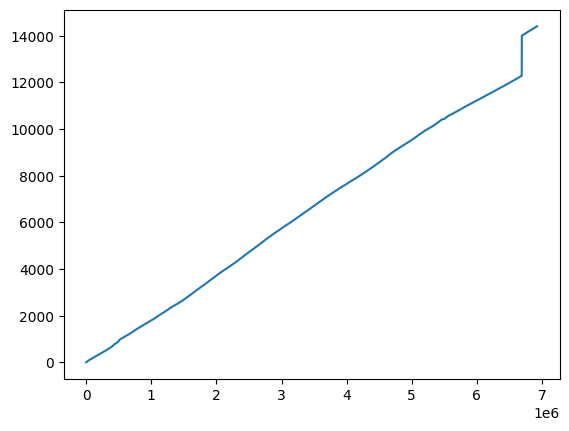

In [12]:
pnum = data.profile_num.values
pnum_orig = pnum.copy()

for idx in np.where(np.diff(pnum) < 0)[0]:
    pnum[idx+1:] = pnum[idx+1:]+pnum_orig[idx]

data['profile_num'] = ('time', pnum)
plt.plot(pnum)
np.count_nonzero(~np.isfinite(pnum)),len(pnum)

### Recaclulate oxygen saturation from the quality controlled oxygen data

Notice high oxygen values (> 110%). These are when the Seabird sensor was contaminated by H2S which messed up measurements. Replace those with lower values.
Thankfully, it's pretty easy to assume than H2S means no oxygen.

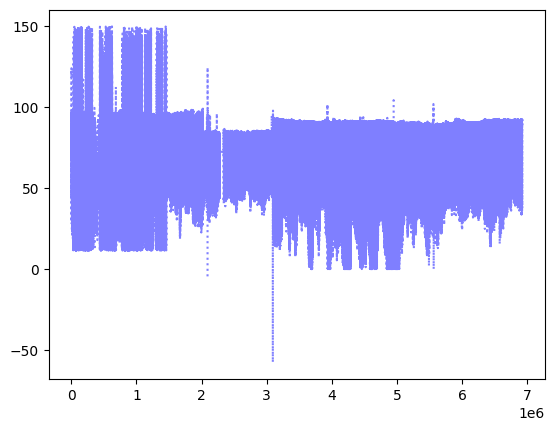

In [13]:
data['o2sat'] = ('time', data.oxygen_concentration.values*100/gsw.O2sol(data.sa.values, data.ct.values, data.pressure.values, data.longitude.values, data.latitude.values))
plt.plot(data.o2sat.values,':b', alpha=0.5)

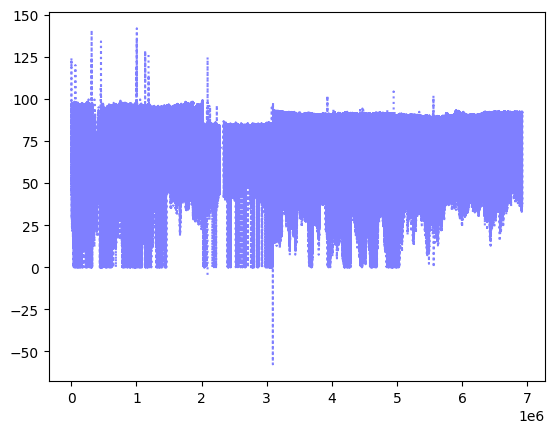

In [14]:
H2S = (data['o2sat'].values > 60) & (data.depth.values > 60) # Keep a record of bad samples.

data['o2sat'][H2S] = 0

plt.plot(data.o2sat.values,':b', alpha=0.5)

# LAG CORRECTIONS

### Create time array for interpolation

In [15]:
time = data.time.values.astype('float')/1e9 # time axis in seconds

time_resolution = 1 # in seconds

tax = np.arange(time[0], time[-1], time_resolution) # 5 second resolution

In [16]:
Vmeth = interpt(time,data.methane_raw_concentration.interpolate_na('time').values,tax)
Vtemp = interpt(time,data.mets_raw_temperature.interpolate_na('time').values,tax)
temp = interpt(time,data.temperature.interpolate_na('time').values,tax)
o2sat = interpt(time,data.o2sat.interpolate_na('time').values,tax)
o2conc = interpt(time,data.oxygen_concentration.interpolate_na('time').values,tax)
depth = interpt(time,data.depth.interpolate_na('time').values,tax)
pnum = np.round(interpt(time,data.profile_num.interpolate_na('time').values,tax))
pitch = interpt(time,data.pitch.interpolate_na('time').values,tax)

lon = interpt(time,data.longitude.interpolate_na('time').values,tax)
lat = interpt(time,data.latitude.interpolate_na('time').values,tax)
sal = interpt(time,data.salinity.interpolate_na('time').values,tax)

### Propagate H2S flag in time

(0.0, 1000000.0)

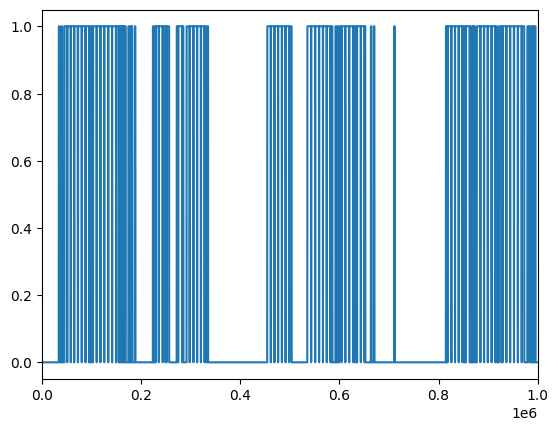

In [17]:
h2s = interpt(time,H2S,tax); 
h2s[h2s>0] = 1
contamination_duration = np.array([60*20 / time_resolution]).astype(int) # in seconds
h2s = np.convolve(h2s, np.concatenate([np.zeros(contamination_duration-1),np.ones(contamination_duration)]), mode='same' )
h2s = h2s.astype(bool)

plt.plot(h2s)

plt.xlim([0, 1e6])

[ 6200  6201  6202  6203  6631  6632  6633  6634  7063  7064  7065  7066
  7494  7495  7496  7497  7926  7927  7928  7929  8357  8358  8359  8360
  8789  8790  8791  8792  9220  9221  9222  9223  9652  9653  9654  9655
 10083 10084 10085 10086 10515 10516 10517 10518 10946 10947 10948 10949
 11378 11379 11380 11381 11809 11810 11811 11812 12241 12242 12243 12244
 12672 12673 12674 12675 13104 13105 13106 13107 13535 13536 13537 13538
 13967 13968 13969 13970 14399 14400 14401 14402]


  0%|          | 0/80 [00:00<?, ?it/s]

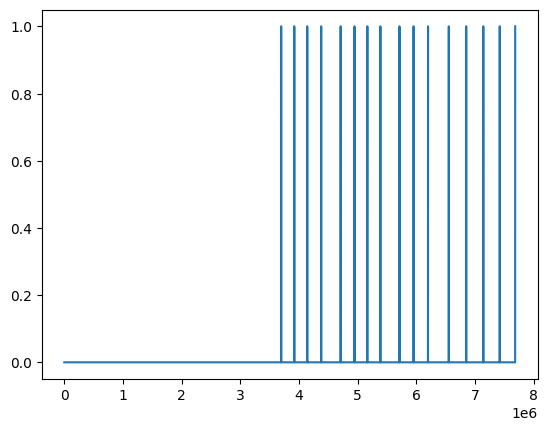

In [18]:
o2sat[~np.isfinite(o2sat)] = 100

idx_profiles = np.linspace(6200, np.max(pnum), 20).astype(int)

idx_profiles = np.concatenate([idx_profiles, idx_profiles+1, idx_profiles+2, idx_profiles+3])
idx_profiles = np.sort(idx_profiles)
print(idx_profiles)

idx = np.full_like(pnum, False)

for istep in tqdm(idx_profiles):
    idx[pnum == istep] = True
    
idx = idx.astype(bool)
    
plt.plot(idx)

### Perform the actual lag correction here

Performing lag correction... Assuming a sampling frequency of 1.0 Hz.
Performing lag correction... Assuming a sampling frequency of 1.0 Hz.
Performing lag correction... Assuming a sampling frequency of 1.0 Hz.


Text(0.5, 1.0, 'best preexisting guess')

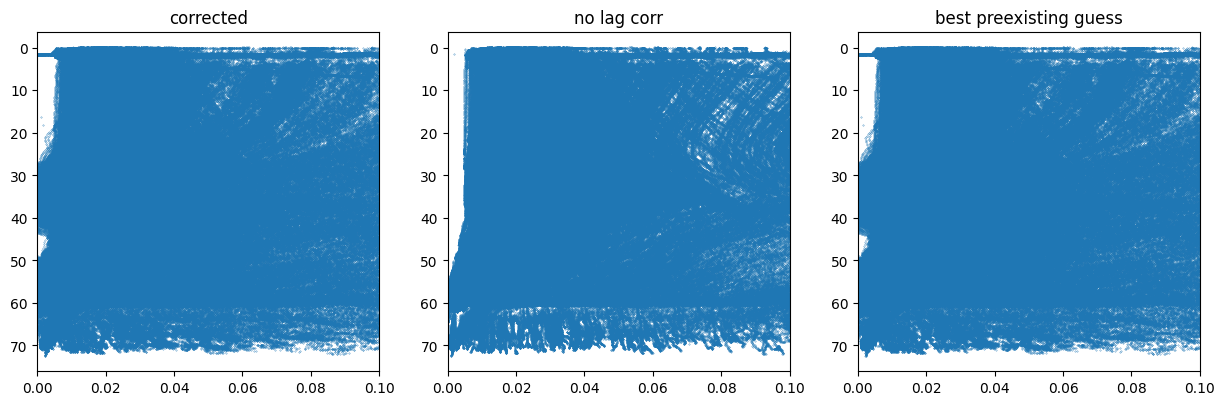

In [29]:
# Several algorithms tested out.
# Ideal would've been a recursive correction (ie. Lueck and Picklo style) but parameter space is a bit too complex to empirically regress from this dataset with no more labwork possible.
# Franatech themselves recommend and use a simple first order lag correction  :: corr = obs + d(obs/dt)

# First order lag dependence tested with velocity dependence due to variable flight speed but the sensitivity of the response was very limited.
# Due to the need for 3 separate corrections (methane membrane diffusion, temperature inside the interstitial space and oxygen diffusion) we keep things simple to get easier minimisation.

# We had good convergence of lag parameters taking missions individually. Here we regress on all and converge on a similar set of parameters. 
# We make the decision to apply the same correction across the board rather than make it mission specific.

# Could not use the default Franatech correction as they basically just smooth over everything over incredibly long timescales... We want to improve it so we can capture at least *some* of the vertical structure

def lagCorrection(referencevariable,time,lag=None):

    _gd = idx    
    _, pgrid = np.unique(pnum[idx], return_inverse=True, equal_nan=True)
    
    Fs = np.mean(1/np.gradient(time))
    print('Performing lag correction... Assuming a sampling frequency of '+str(Fs)+' Hz.')
    fn = Fs/2
    
    window = np.array([30/time_resolution]).astype(int)
    
    def smooth(x):
        return np.convolve(x, np.ones(window)/window, mode='same')
    
    def _Correction(coeffs):
        coeffs = [x/time_resolution for x in coeffs]
        
        meth_lag = coeffs[0]
        temp_lag = coeffs[1]
        o2_lag   = coeffs[2]
        
        temp_voltage = realT2metsT(_Lag(metsT2realT(Vtemp),temp_lag))
        
        methane = calc_methane(Vmeth,temp_voltage)
        methane = _Lag(methane,meth_lag)
        methane = o2_corr(methane, _Lag(o2sat,o2_lag))
        return methane
    
    def _Lag(variable, tau):
        return variable + tau * np.gradient(smooth(variable),time)
    
    if lag is None:
        def _PolyArea(x):
            V,_,_ = grid2d(pgrid, referencevariable[_gd], x[_gd])
            return np.nanmean((V[:, 0:-1:2] - V[:, 1::2])**2)
            
        def _f(x):
            return _PolyArea(_Correction(x))
        print('Regressing lag coefficient:')
        minimum = optimize.fmin(_f, [0,0,0], disp=True, full_output=True)
        print('Calculated lag coefficient = '+np.array2string(minimum[0]))
        lag = minimum[0]

    return _Correction(lag)

def do_full(lag=None):
    return lagCorrection(depth,tax,lag)



corr  = do_full([133.92675443, 3.78434691, -24.02787511])

raw   = do_full([0,0,0]) # 
other = do_full([133.92675443, 3.78434691, -24.02787511]) # Backup



plt.close('all')
plt.figure(figsize=(15,15))


plt.subplot(334)
plt.plot(corr[idx], depth[idx], linestyle='none', marker='.', markersize=0.5)
plt.gca().invert_yaxis()
plt.xlim([0,0.1])
plt.title('corrected')

plt.subplot(335)
plt.plot(raw[idx], depth[idx], linestyle='none', marker='.', markersize=0.5)
plt.gca().invert_yaxis()
plt.xlim([0,0.1])
plt.title('no lag corr')

plt.subplot(336)
plt.plot(other[idx], depth[idx], linestyle='none', marker='.', markersize=0.5)
plt.gca().invert_yaxis()
plt.xlim([0,0.1])
plt.title('best preexisting guess')

# VALIDATION PLOTS

### Compare the "corrected" temperature to the real temperature

Optimization terminated successfully.
         Current function value: 0.542548
         Iterations: 89
         Function evaluations: 168
[63.58877252  0.08775787]


Text(0.5, 1.0, 'Utilised temperature from loading algorithm')

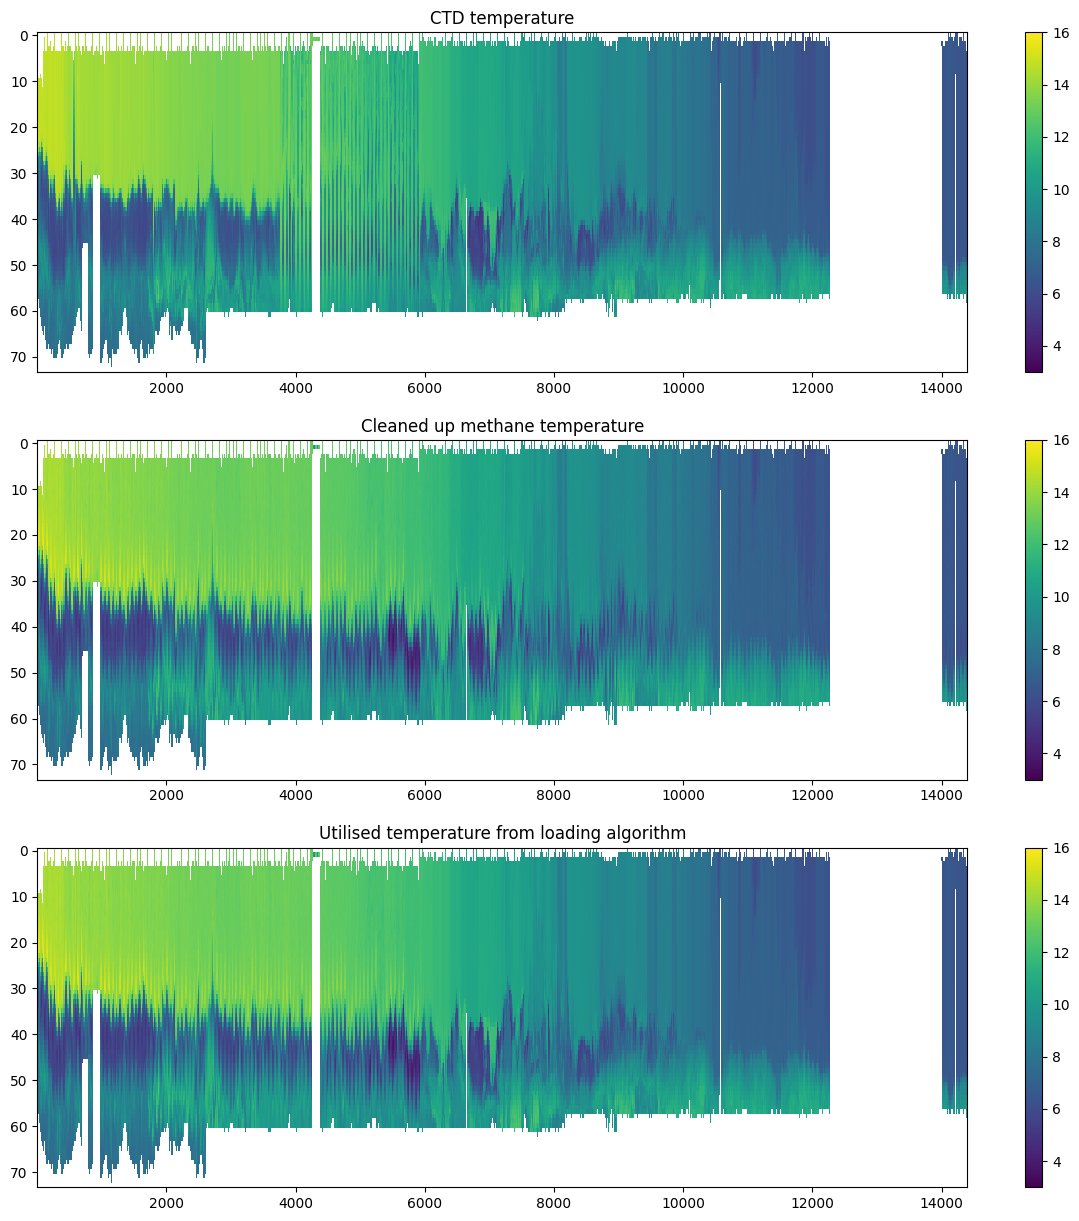

In [30]:
adcpT = metsT2realT(Vtemp)
legT = interpt(time,data.original_temperature.interpolate_na('time').values, tax)
used = temp

_early = pnum > 6000

window = np.array([10/time_resolution]).astype(int)

def smooth(x):
    return np.convolve(x, np.ones(window)/window, mode='same')

def rmsd(x):
    return np.sqrt(np.nanmean((fixT(x)[_early]-legT[_early])**2))

def fixT(x):
    return adcpT + x[0] * np.gradient(smooth(adcpT),tax) + x[1]

from scipy import optimize 
R = optimize.fmin(rmsd, [0,0])
print(R)
new_T = fixT(R)

plt.figure(figsize=(15,15))

plt.subplot(311)
V,X,Y = grid2d(pnum, depth, smooth(legT))
plt.pcolormesh(X,Y,V)
plt.gca().invert_yaxis()
plt.colorbar()
plt.clim([3,16])
plt.title('CTD temperature')

plt.subplot(312)
V,X,Y = grid2d(pnum, depth, smooth(new_T))
plt.pcolormesh(X,Y,V)
plt.gca().invert_yaxis()
plt.colorbar()
plt.clim([3,16])
plt.title('Cleaned up methane temperature')

plt.subplot(313)
TEMPERATURE_GRID,X,Y = grid2d(pnum, depth, smooth(used))
plt.pcolormesh(X,Y,TEMPERATURE_GRID)
plt.gca().invert_yaxis()
plt.colorbar()
plt.clim([3,16])
plt.title('Utilised temperature from loading algorithm')

### Other variables

Text(0.5, 1.0, 'O2_sat')

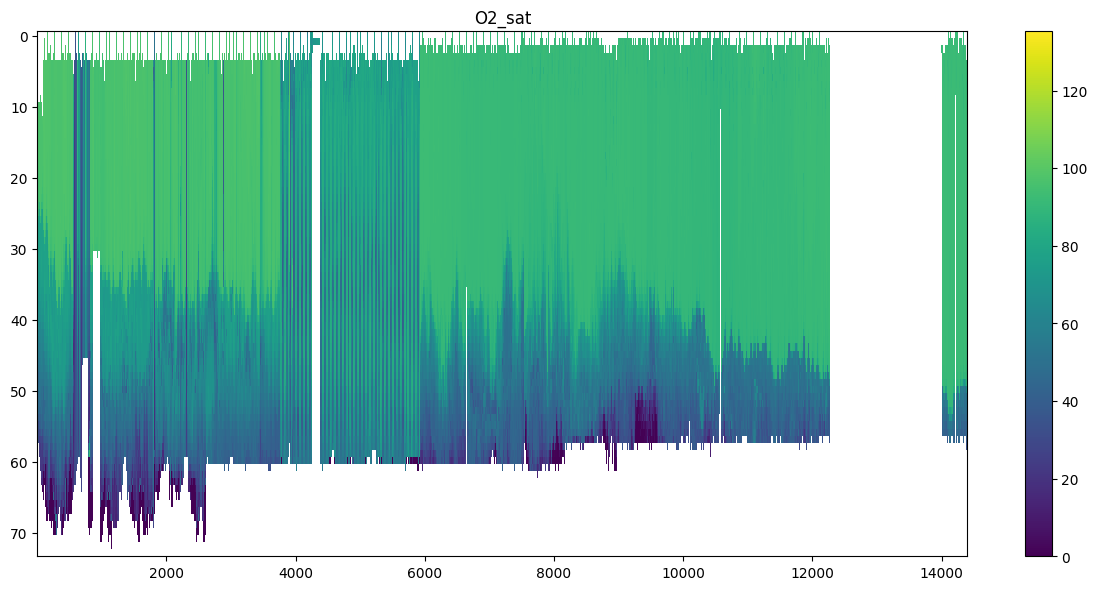

In [31]:
plt.figure(figsize=(15,15))

plt.subplot(211)
V,X,Y = grid2d(pnum, depth, o2sat)
plt.pcolormesh(X,Y,V)
plt.gca().invert_yaxis()
plt.colorbar()
# plt.clim([-4,0.5])
# plt.clim([0,5])
plt.title('O2_sat')


# VISUALISE METHANE DATA

/tmp/ipykernel_937527/332949197.py:4: RuntimeWarning: invalid value encountered in log10
  V,X,Y = grid2d(pnum, depth, np.log10(corr))
/tmp/ipykernel_937527/332949197.py:15: RuntimeWarning: invalid value encountered in log10
  V,X,Y = grid2d(np.floor(pnum[idx]/2), depth[idx], np.log10(corr[idx]))
/tmp/ipykernel_937527/332949197.py:24: RuntimeWarning: invalid value encountered in log10
  V,X,Y = grid2d(np.floor(pnum[idx]/2), depth[idx], np.log10(corr[idx]))


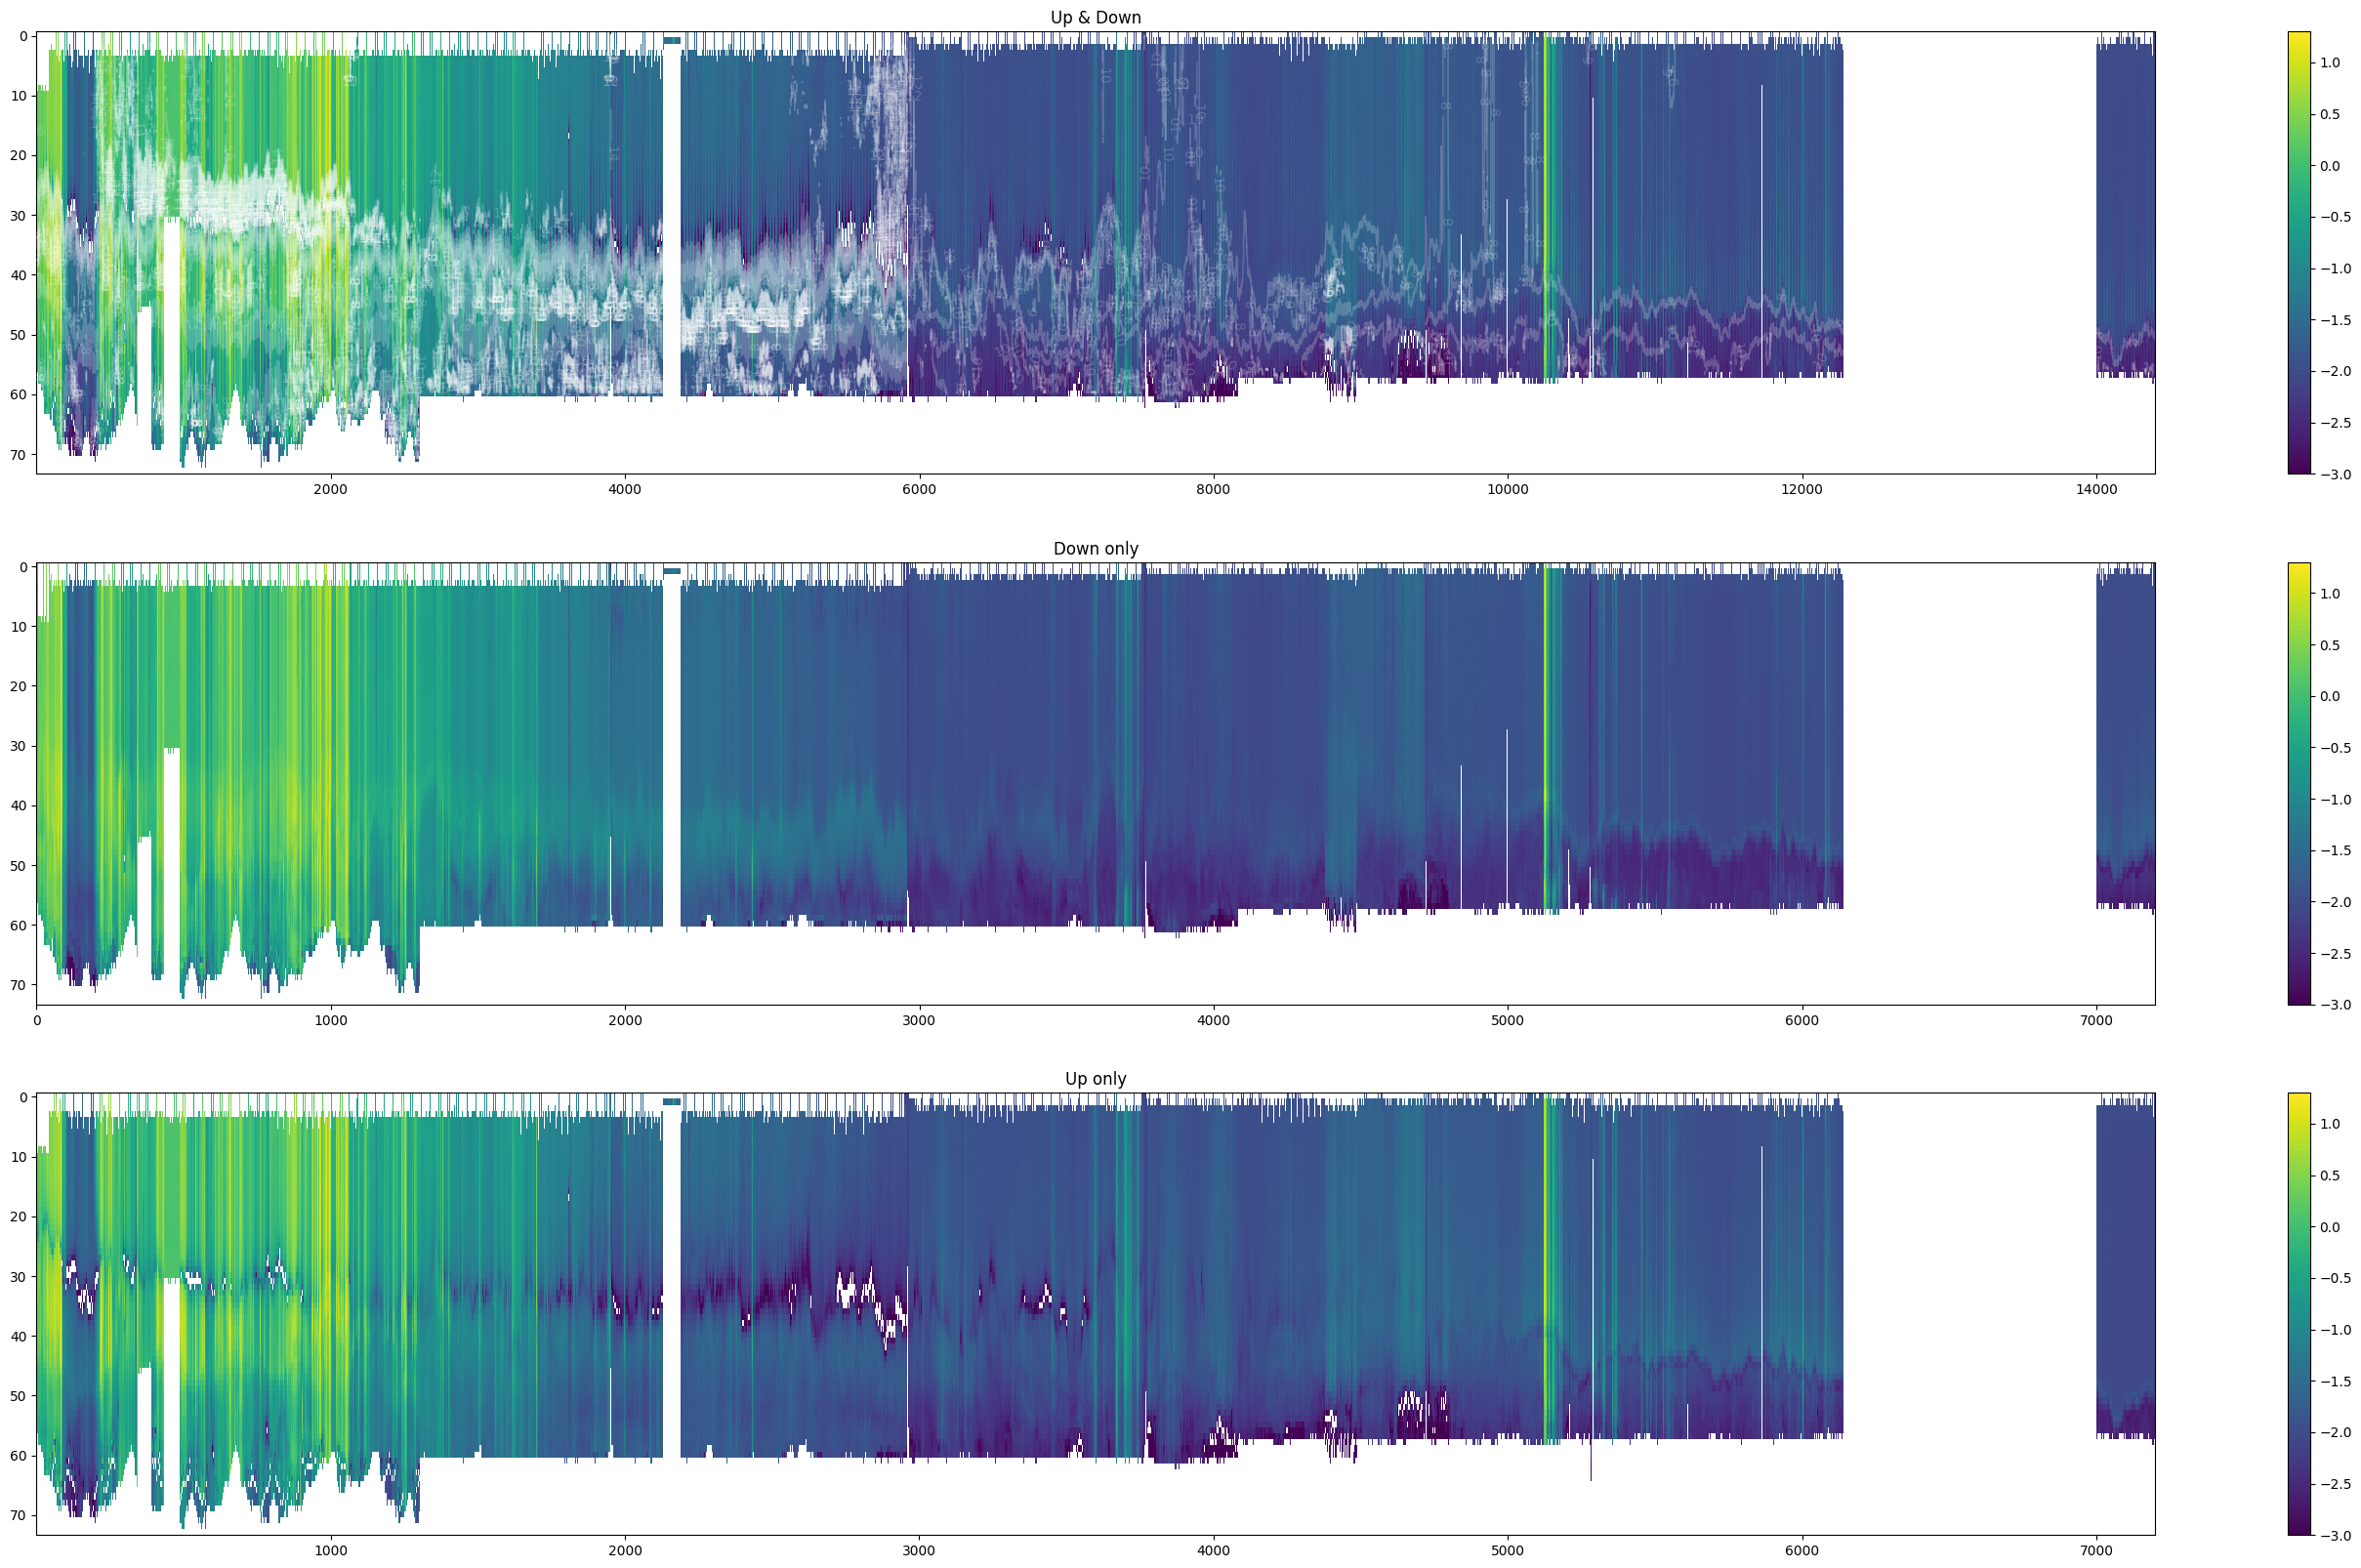

In [32]:
plt.figure(figsize=(35,20))

plt.subplot(311)
V,X,Y = grid2d(pnum, depth, np.log10(corr))
plt.pcolormesh(X, Y, V)
plt.colorbar()
plt.clim([-3,1.3])
ch = plt.contour(X,Y,TEMPERATURE_GRID, np.arange(0,50,2), colors='w', linewidths=1, linestyles='-', alpha=0.2)
plt.clabel(ch)
plt.title('Up & Down')
plt.gca().invert_yaxis()

plt.subplot(312)
idx = np.remainder(pnum,2) == 1
V,X,Y = grid2d(np.floor(pnum[idx]/2), depth[idx], np.log10(corr[idx]))
plt.pcolormesh(X, Y, V)
plt.colorbar()
plt.clim([-3,1.3])
plt.title('Down only')
plt.gca().invert_yaxis()

plt.subplot(313)
idx = np.remainder(pnum,2) == 0
V,X,Y = grid2d(np.floor(pnum[idx]/2), depth[idx], np.log10(corr[idx]))
plt.pcolormesh(X, Y, V)
plt.colorbar()
plt.clim([-3,1.3])
plt.title('Up only')
plt.gca().invert_yaxis()



In [33]:
to_plot = ~h2s & (np.remainder(pnum,2) == 0) # See only one cast

/tmp/ipykernel_937527/2666675042.py:4: RuntimeWarning: invalid value encountered in log10
  V,X,Y = grid2d(tax[to_plot], lon[to_plot], np.log10(corr[to_plot]), xi=np.linspace(tax[0],tax[-1],3000), yi=np.linspace(np.min(lon), np.max(lon), 100))
/tmp/ipykernel_937527/2666675042.py:13: RuntimeWarning: invalid value encountered in log10
  V,X,Y = grid2d(tax, lon, np.log10(corr), xi=np.linspace(tax[0],tax[-1],3000), yi=np.linspace(np.min(lon), np.max(lon), 100))


Text(0.5, 1.0, 'Longitude')

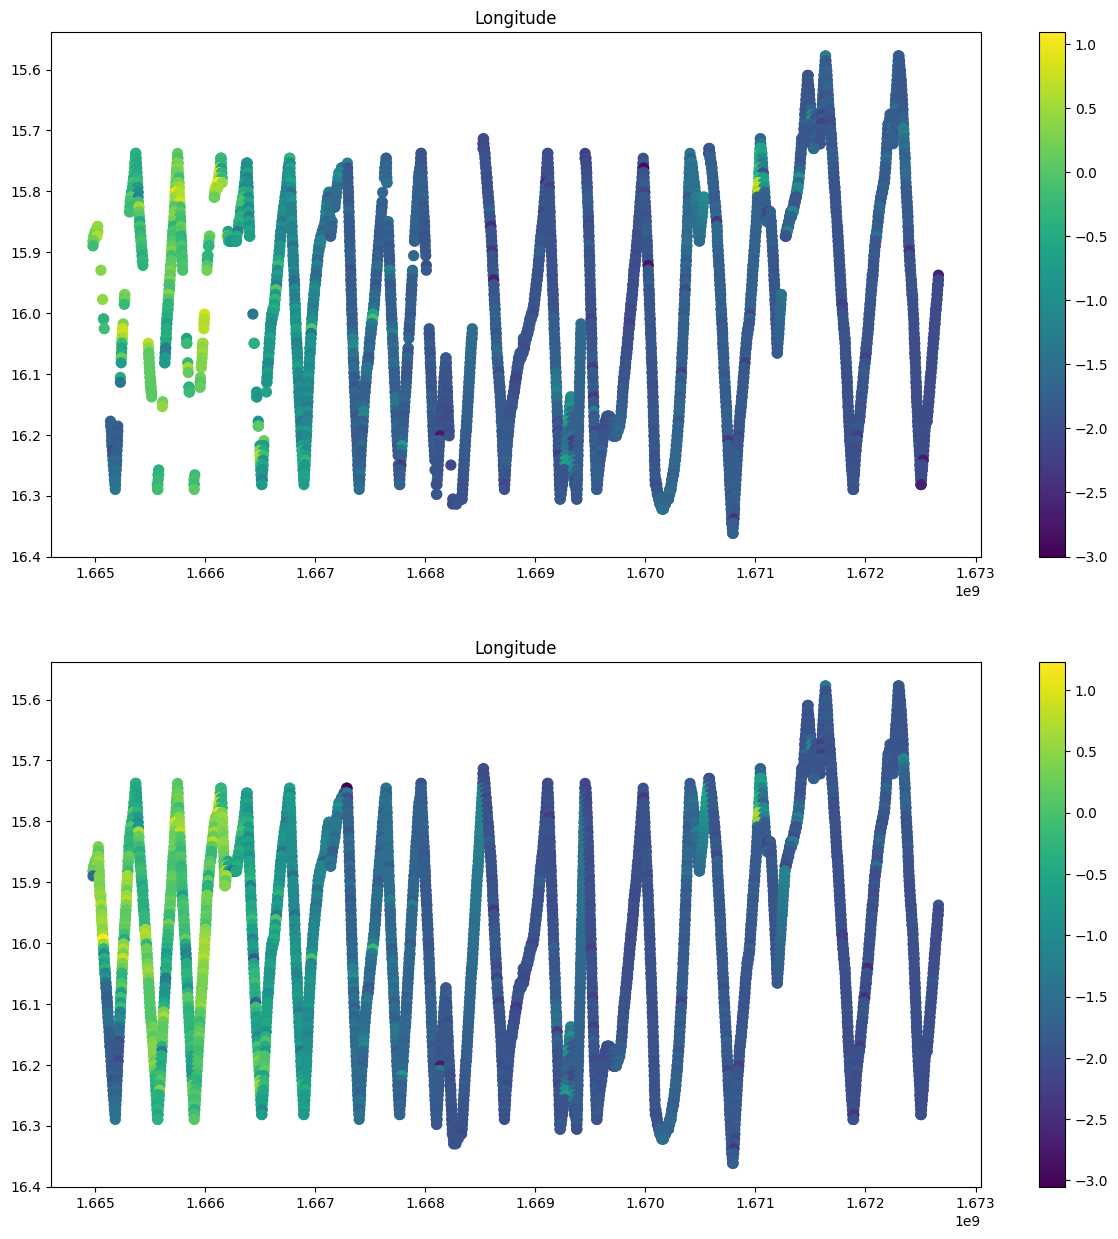

In [34]:
plt.figure(figsize=(15,15))

plt.subplot(211)
V,X,Y = grid2d(tax[to_plot], lon[to_plot], np.log10(corr[to_plot]), xi=np.linspace(tax[0],tax[-1],3000), yi=np.linspace(np.min(lon), np.max(lon), 100))
plt.scatter(X,Y,50,V)
plt.gca().invert_yaxis()
plt.colorbar()
# plt.clim([-4,0.5])
# plt.clim([-3,1])
plt.title('Longitude')

plt.subplot(212)
V,X,Y = grid2d(tax, lon, np.log10(corr), xi=np.linspace(tax[0],tax[-1],3000), yi=np.linspace(np.min(lon), np.max(lon), 100))
plt.scatter(X,Y,50,V)
plt.gca().invert_yaxis()
plt.colorbar()
# plt.clim([-4,0.5])
# plt.clim([-3,1])
plt.title('Longitude')

# EXPORT DATASET

In [69]:
tax_ns = tax*1e9

# create dataset
ds = xr.Dataset({
    'methane': xr.DataArray(
                data   = corr,
                dims   = ['time'],
                coords = {'time': pd.to_datetime(tax_ns)},
                ),
    'methane_ftech': xr.DataArray(
                data   = fmeth,
                dims   = ['time'],
                coords = {'time': pd.to_datetime(tax_ns)},
                ),
    'temperature': xr.DataArray(
                data   = temp,
                dims   = ['time'],
                coords = {'time': pd.to_datetime(tax_ns)},
                ),
    'depth': xr.DataArray(
                data   = depth,
                dims   = ['time'],
                coords = {'time': pd.to_datetime(tax_ns)},
                ),
    'profile_num': xr.DataArray(
                data   = pnum,
                dims   = ['time'],
                coords = {'time': pd.to_datetime(tax_ns)},
                ),
    'longitude': xr.DataArray(
                data   = lon,
                dims   = ['time'],
                coords = {'time': pd.to_datetime(tax_ns)},
                ),
    'latitude': xr.DataArray(
                data   = lat,
                dims   = ['time'],
                coords = {'time': pd.to_datetime(tax_ns)},
                ),
    'salinity': xr.DataArray(
                data   = sal,
                dims   = ['time'],
                coords = {'time': pd.to_datetime(tax_ns)},
                ),
    'oxy_conc': xr.DataArray(
                data   = o2conc,
                dims   = ['time'],
                coords = {'time': pd.to_datetime(tax_ns)},
                ),
    'H2S_mask': xr.DataArray(
                data   = h2s,
                dims   = ['time'],
                coords = {'time': pd.to_datetime(tax_ns)},
                )
            },
        attrs = {'Time stamp': datetime.datetime.now().strftime("%m/%d/%Y, %H:%M:%S")}
    )

ds.to_netcdf('timeseries_output.nc')


In [70]:
sanity_check = xr.open_dataset('timeseries_output.nc')
sanity_check

<xarray.Dataset>
Dimensions:        (time: 7683561)
Coordinates:
  * time           (time) datetime64[ns] 2022-10-05T14:59:35.092999936 ... 20...
Data variables:
    methane        (time) float64 ...
    methane_ftech  (time) float64 ...
    temperature    (time) float64 ...
    depth          (time) float64 ...
    profile_num    (time) float64 ...
    longitude      (time) float64 ...
    latitude       (time) float64 ...
    salinity       (time) float64 ...
    oxy_conc       (time) float64 ...
    H2S_mask       (time) bool ...
Attributes:
    Time stamp:  08/31/2023, 13:01:13

In [71]:
sanity_check.close()

In [72]:
len(depth)

7683561